# Project: China Scientific Leadership

**Notebook:** FigS22_China_US_parity_in_6_broad_fields.ipynb

**Authors:** Renli Wu, Christopher Esposito, James Evans

**Affiliations:** School of Information Management, Wuhan University / Knowledge Lab, University of Chicago / University of California, Los Angeles

**Date:** 2024-11-29 (UTC)
**Version:** v0.3.0

**Purpose:**
This notebook generates **Figure S22** for the Supplementary Information, which includes both the **Lead Share version** and the **Lead Premium version**.
Both the Lead Share and Lead Premium versions are equally important, as they provide complementary perspectives on leadership distribution.

In addition, the notebook can generate the supplementary figure (**Fig. S21**) showing the publication statistics across the six broad fields.

**Inputs:**
- `data/OpenAlex2023_Paper_Author_Lead_Pro_dataset.csv.gz`

**Outputs:**
- `pics/fig_S22_lead_share.svg`
- `pics/fig_S22_lead_premium.svg`

**Notes:**
See `README.md` for details on environment setup, dependencies, and execution order within the full analysis pipeline.


In [1]:
import numpy as np
import pandas as pd
import time

### Load the leadership dataset

In [2]:
%%time
print(time.strftime('%l:%M%p %Z on %b %d, %Y'))
data = pd.read_csv("./data/OpenAlex2023_Paper_Author_Lead_Pro_dataset.csv.gz", compression="gzip")
print(time.strftime('%l:%M%p %Z on %b %d, %Y'), data.shape)
data.head()

 7:11AM CDT on Sep 17, 2025


<timed exec>:2: DtypeWarning: Columns (9,14,15) have mixed types. Specify dtype option on import or set low_memory=False.


 7:13AM CDT on Sep 17, 2025 (42995311, 22)
CPU times: user 1min 59s, sys: 10.3 s, total: 2min 9s
Wall time: 2min 9s


,paperId,authorId,publication_year,Lead_Pro,region,China_US,China_EU+,China_UK,US_EU+,UK_EU+,...,China_BeltRoad_HighIncome,China_BeltRoad_LowIncome,US_BeltRoad_HighIncome,US_BeltRoad_LowIncome,jif_2021,jif_mid,11_technical_area,fos_6,Honorary_authors,Matched_in_WOS
0,W3135965258,A5021665664,2021,0.155624,East Asia,False,False,False,False,False,...,False,False,NaN,NaN,1-5,3.0,DIS;EG;HPC;MAT;SC,earth & life science;chemistry & materials sci...,False,True
1,W3135965258,A5032223512,2021,0.263628,East Asia,False,False,False,False,False,...,False,False,NaN,NaN,1-5,3.0,DIS;EG;HPC;MAT;SC,earth & life science;chemistry & materials sci...,False,True
2,W3135978430,A5058653785,2021,0.300942,EU+,False,False,False,False,False,...,False,False,NaN,NaN,5-10,7.5,DIS;EG;MAT,mathematics & physics & engineering;chemistry ...,False,True
3,W3135978430,A5062473161,2021,0.689903,EU+,False,False,False,False,False,...,False,False,NaN,NaN,5-10,7.5,DIS;EG;MAT,mathematics & physics & engineering;chemistry ...,False,True
4,W3135978430,A5006524513,2021,0.242909,Latin America,False,False,False,False,False,...,False,False,NaN,NaN,5-10,7.5,DIS;EG;MAT,mathematics & physics & engineering;chemistry ...,False,True


### Main text - China's lead parity in 6 major fields

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
from sklearn.linear_model import LinearRegression
from scipy.stats import t as student_t
from tqdm import tqdm

# ---------- Parameters ----------
c1, c2 = "China", "U.S."
pair_col = f"{c1.replace('.', '')}_{c2.replace('.', '')}"
cols_needed = ["paperId","authorId","Lead_Pro","publication_year","region","fos_6"]

begin_year_plot = 2010                  # x-axis start for panels
year_tuple_list = [(y, y) for y in range(1995, 2024)]
reg_min_year    = 2015                  # regression uses years >= this
min_pub_per_yr  = 100                   # min unique papers per (field, year) to include
lead_threshold  = 0.65                  # Lead_Pro split for lead vs muscle
conf_level      = 0.95
future_years    = np.arange(2023, 2031).reshape(-1, 1)

# Abbreviations → pretty names (legend/axes)
field_title = {
    "chemistry & materials science": "Chemistry and Materials Science",
    "computer science": "Computer Science",
    "earth & life science": "Earth and Life Sciences",
    "humanity & social science": "Humanities and Social Sciences",
    "mathematics & physics & engineering": "Mathematics, Physics, and Engineering",
    "medicine": "Medical Sciences"
}


# ---------- Styling ----------
sns.set_theme(style="whitegrid")
plt.style.use('fivethirtyeight')

In [4]:
# ---------- Helpers ----------
def _bins(n=20):
    """Uniform bins over [0, 1] for Lead_Pro density aggregation."""
    return np.linspace(0, 1, n+1)

def midpoint(iv: pd.Interval) -> float:
    """Midpoint of a pandas Interval."""
    return float(iv.mid)

def _fit_linreg_with_ci(X_1d, Y_1d, future_years, conf_level=0.95):
    """
    Fit Y ~ year, return dict with:
      model, r_sq, X, Y, y_pred, st_err, x_mean, t_val,
      df_plot (Year, Predictions, Lower Bound, Upper Bound),
      df_future_plot (Year, Predictions, Lower Bound, Upper Bound)
    """
    X = np.asarray(X_1d, dtype=float).reshape(-1, 1)
    Y = np.asarray(Y_1d, dtype=float).reshape(-1, 1)
    model = LinearRegression().fit(X, Y)
    r_sq  = float(model.score(X, Y))

    y_pred = model.predict(X)
    resid  = Y - y_pred
    n      = len(X)
    if n <= 2:
        return None

    sse    = float(np.sum(resid**2))
    st_err = np.sqrt(sse / (n - 2))
    x_mean = float(np.mean(X))
    sxx    = float(np.sum((X - x_mean)**2))
    t_val  = float(student_t.ppf((1 + conf_level) / 2, df=n - 2))

    # Current CI
    ci = t_val * st_err * np.sqrt(1/n + (X - x_mean)**2 / sxx)
    lower = (y_pred - ci).ravel()
    upper = (y_pred + ci).ravel()

    df_plot = pd.DataFrame({
        "Year": X.ravel(),
        "Predictions": y_pred.ravel(),
        "Lower Bound": lower,
        "Upper Bound": upper
    })

    # Future CI
    fut = np.asarray(future_years, dtype=float).reshape(-1, 1)
    fut_pred = model.predict(fut)
    ci_future = t_val * st_err * np.sqrt(1/n + (fut - x_mean)**2 / sxx)
    lower_f = (fut_pred - ci_future).ravel()
    upper_f = (fut_pred + ci_future).ravel()

    df_future_plot = pd.DataFrame({
        "Year": fut.ravel(),
        "Predictions": fut_pred.ravel(),
        "Lower Bound": lower_f,
        "Upper Bound": upper_f
    })

    return dict(model=model, r_sq=r_sq, X=X, Y=Y, y_pred=y_pred,
                st_err=st_err, x_mean=x_mean, t_val=t_val,
                df_plot=df_plot, df_future_plot=df_future_plot)

def _ci_bounds_at_year(x0, X, x_mean, t_val, st_err, sxx, n, model):
    """Mean-prediction CI at scalar year x0. Returns (lo, hi)."""
    x0 = float(x0)
    y_hat = float(model.predict(np.array([[x0]])))
    se_mean = float(st_err * np.sqrt(1/n + ((x0 - x_mean) ** 2) / sxx))
    lo = y_hat - t_val * se_mean
    hi = y_hat + t_val * se_mean
    return lo, hi

def scan_parity_interval(equal_line, model, X, x_mean, t_val, st_err, scan_start=2000, scan_end=2500):
    """
    Scan integer years to find the first and last years where CI encloses equal_line.
    Map out-of-range [<=1999 or >=2300] to "Never".
    """
    n = len(X)
    sxx = float(np.sum((X - x_mean)**2))
    lower, upper = None, None
    for yr in range(scan_start, scan_end):
        lo, hi = _ci_bounds_at_year(yr, X, x_mean, t_val, st_err, sxx, n, model)
        if np.round(lo, 2) <= equal_line <= np.round(hi, 2):
            if lower is None:
                lower = int(yr)
            upper = int(yr)
    if lower is None:
        return "Never", "Never"
    if lower <= 1999 or lower >= 2300:
        lower = "Never"
    if upper <= 1999 or upper >= 2300:
        upper = "Never"
    return lower, upper

def parity_legend_text(lower_int, upper_int):
    """Legend text rules with sorted interval; if hi>2200 → 'Parity after lo'."""
    if upper_int == lower_int == "Never":
        legend_text = "Never Parity"
    elif "Never" in [lower_int, upper_int]:
        # ensure the non-"Never" value comes first
        lo, hi = (lower_int, upper_int) if lower_int != "Never" else (upper_int, lower_int)
        legend_text = f"Parity after {lo}"
    elif upper_int == lower_int:
        legend_text = f"Parity {upper_int}"
    else:
        lo, hi = sorted([lower_int, upper_int])
        legend_text = f"Parity after {lo}" if hi > 2200 else f"Parity {lo}-{hi}"
    return legend_text



In [5]:
# ---------- Data subset & canonicalize technical areas ----------
obs = (
    data.loc[(data[pair_col]) & (data["publication_year"] >= 2000), cols_needed]
        .drop_duplicates(["paperId","authorId","region"])
        .copy()
)

# Parse semicolon-separated list into Python lists
obs["fos_6"] = obs["fos_6"].apply(
    lambda x: (
        np.nan
        if not isinstance(x, str) or not x.strip()
        else [c.strip() for c in x.split(";") if c.strip()] or np.nan
    )
)
obs.dropna(subset=["fos_6"], inplace=True)

# ---------- Paper count by field/year ----------
cat_list = list(field_title.keys())

sta_rows = []
for cat in tqdm(cat_list, total=len(cat_list)):
    temp_obs = obs[obs["fos_6"].apply(lambda lst: cat in lst)]
    for (st_year, end_year) in year_tuple_list:
        tmp = temp_obs[temp_obs["publication_year"].between(st_year, end_year)].drop_duplicates(["paperId"], keep="first")
        sta_rows.append([c1, c2, cat, st_year, end_year, len(tmp)])

df_paper_sta = pd.DataFrame(sta_rows, columns=["c1","c2","field","st_year","end_year","pub_count"])
df_paper_sta["year"] = (df_paper_sta["st_year"] + df_paper_sta["end_year"]) / 2

100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


In [6]:
# Color palette per field
import matplotlib
cmap = matplotlib.colormaps["Set3"]
hue_colors = {cat_list[i]: cmap(i % 10) for i in range(len(cat_list))}
hue_colors["computer science"] = "#ff8800"

In [7]:
# ---------- Build per-field yearly metrics at a fixed lead_threshold ----------
def compute_field_year_metrics(obs, fields, years, lead_threshold=0.65, min_pub=min_pub_per_yr):
    """
    For each field and year, compute c1_lead_share and lead_premium using counts
    from Lead_Pro density (binned) by region. Returns tidy DataFrame.
    """
    rows = []
    val_bins = _bins(20)
    for cat in tqdm(fields, total=len(fields)):
        temp_obs = obs if cat == "All Critical Tech Areas" else obs[obs["fos_6"].apply(lambda lst: cat in lst)]
        for (st_year, end_year) in years:
            sub = temp_obs[temp_obs["publication_year"].between(st_year, end_year)].copy()
            sub = sub.drop_duplicates(["paperId","authorId","region"])
            pub_count = sub["paperId"].nunique()
            if pub_count < min_pub:
                continue

            sub["val_bins"] = pd.cut(sub["Lead_Pro"], bins=val_bins, include_lowest=True)
            sta = (sub.groupby(["region","val_bins"], observed=True)
                      .size().rename("count").reset_index())
            sta["val_midpoints"] = sta["val_bins"].apply(midpoint).astype(float)

            wide = (sta.pivot(index="val_midpoints", columns="region", values="count")
                      .reindex(columns=[c1, c2]).fillna(0.0).reset_index())

            c1_lead  = wide.loc[wide["val_midpoints"] >  lead_threshold, c1].sum()
            c2_lead  = wide.loc[wide["val_midpoints"] >  lead_threshold, c2].sum()
            c1_musc  = wide.loc[wide["val_midpoints"] <= lead_threshold, c1].sum()
            c2_musc  = wide.loc[wide["val_midpoints"] <= lead_threshold, c2].sum()

            denom_lead = c1_lead + c2_lead
            denom_musc = c1_musc + c2_musc
            c1_share   = (c1_lead / denom_lead) if denom_lead > 0 else np.nan
            premium    = (c1_lead / denom_lead - c1_musc / denom_musc) if (denom_lead > 0 and denom_musc > 0) else np.nan

            rows.append([cat, st_year, end_year, (st_year+end_year)/2, pub_count, c1_share, premium])

    return pd.DataFrame(rows, columns=["field","st_year","end_year","year","pub_num","c1_lead_share","lead_premium"])

df_field_year = compute_field_year_metrics(
    obs=obs, fields=cat_list, years=[(y, y) for y in range(2010, 2024)],
    lead_threshold=lead_threshold, min_pub=min_pub_per_yr
)

100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


In [8]:
# ---------- Panel plot generator ----------
def plot_panels(df_draw, metric, equal_line, y_range, title_suffix, save_file_name):
    """
    Draw 12 panels (fields) with:
      - scatter of yearly metric
      - regression with CI for observed years (>= reg_min_year)
      - dashed forecasts with CI for 2023–2030
      - parity equal line and x=2023 line
      - parity interval legend text (based on CI scan)
    """
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(23, 13))
    fig.subplots_adjust(wspace=0.15, hspace=0.3)
    axes = axes.flatten()
    fig.patch.set_facecolor('white')

    fields_in_order = cat_list  # reverse for similar layout
    for ax, fos in zip(axes, fields_in_order):
        cur = df_draw[(df_draw["field"] == fos) & (df_draw["year"] >= reg_min_year) & (df_draw[metric].notna())]
        # Require at least 3 points for regression
        if cur.shape[0] < 3:
            ax.axis('off')
            continue

        # Fit regression + CIs
        fit = _fit_linreg_with_ci(cur["year"].values, cur[metric].values, future_years, conf_level=conf_level)
        if fit is None:
            ax.axis('off')
            continue

        model, r_sq = fit["model"], fit["r_sq"]
        X, x_mean, t_val, st_err = fit["X"], fit["x_mean"], fit["t_val"], fit["st_err"]
        df_plot, df_future_plot = fit["df_plot"], fit["df_future_plot"]

        # Scatter historical points (use raw yearly values from full df for completeness)
        cur_all = df_draw[(df_draw["field"] == fos) & (df_draw[metric].notna())]
        current_color = hue_colors.get(fos, "#999999")
        sns.scatterplot(data=cur_all, x="year", y=metric, color=current_color, s=100, ax=ax)

        # Regression line + CI (observed)
        sns.lineplot(data=df_plot, x="Year", y="Predictions", linewidth=4, color=current_color, ax=ax)
        sns.lineplot(data=df_plot, x="Year", y="Lower Bound", linewidth=2, color=current_color, linestyle='--', ax=ax)
        sns.lineplot(data=df_plot, x="Year", y="Upper Bound", linewidth=2, color=current_color, linestyle='--', ax=ax)
        ax.fill_between(df_plot['Year'], df_plot['Lower Bound'], df_plot['Upper Bound'], color=current_color, alpha=0.2)

        # Forecast line + CI (future)
        sns.lineplot(data=df_future_plot, x="Year", y="Predictions", color=current_color, linewidth=4, linestyle='dashed', ax=ax)
        sns.lineplot(data=df_future_plot, x="Year", y="Lower Bound", color=current_color, linewidth=2, linestyle='--', ax=ax)
        sns.lineplot(data=df_future_plot, x="Year", y="Upper Bound", color=current_color, linewidth=2, linestyle='--', ax=ax)
        ax.fill_between(df_future_plot['Year'], df_future_plot['Lower Bound'], df_future_plot['Upper Bound'], color=current_color, alpha=0.2)

        # Parity scan (CI-based)
        lower_int, upper_int = scan_parity_interval(
            equal_line=equal_line, model=model, X=X, x_mean=x_mean, t_val=t_val, st_err=st_err,
            scan_start=2015, scan_end=2500
        )
        legend_text = parity_legend_text(lower_int, upper_int)

        # Guides
        ax.axhline(equal_line, color="black", linestyle="solid", linewidth=3, alpha=0.7, zorder=1)
        ax.axvline(2023,      color="black", linestyle="solid", linewidth=3, alpha=0.7, zorder=1)

        # Axis config
        y_min, y_max = y_range
        ax.set_ylim(y_min, min(1, y_max) + (0.03 if metric == "c1_lead_share" else 0.00))
        y_ticks = np.arange(y_min, min(1, y_max) + 1e-9, 0.25)
        ax.yaxis.set_major_locator(FixedLocator(y_ticks))
        ax.set_yticklabels([f"{i:.2f}" for i in y_ticks], fontsize=21)

        ticks = np.arange(begin_year_plot, 2031, 5).tolist()
        ticks.append(2023); ticks.sort()
        ax.xaxis.set_major_locator(FixedLocator(ticks))
        ax.set_xticklabels(ticks, fontsize=21)
        ax.tick_params(axis='x', which='both', pad=8)

        # Vertical grid lines
        ax.yaxis.grid(False)
        for xv in np.arange(begin_year_plot, 2031, 5):
            ax.axvline(x=xv, linestyle='-', linewidth=1, color='grey', alpha=0.8, zorder=-1)

        # Labels and title
        ylabel_name = "Lead Share" if metric == "c1_lead_share" else "Lead Premium"
        ax.set_xlabel("Year", labelpad=5, weight='bold', fontsize=25)
        ax.set_ylabel(ylabel_name, labelpad=5, weight='bold', fontsize=25)
        ax.set_title(f"{field_title.get(fos, fos)}", pad=12, fontweight='bold', fontsize=30)
        ax.set_xlim(begin_year_plot-1, 2030 + 1)
        # In-panel legend text (CI parity window)
        ax.text(x=0.05, y=0.76, s=legend_text, transform=ax.transAxes, color=current_color, weight='bold',fontsize=30)
        ax.text(x=0.038, y=0.86, s="China–U.S. cooperation", transform=ax.transAxes, color=current_color, weight='bold', fontsize=23)
        ax.set_facecolor("white")
        # Clean legend
        leg = ax.get_legend()
        if leg: leg.remove()

    # Global title & save
    top_title = f"{c1} chasing {c2} — {title_suffix}"
    fig.suptitle(top_title, fontsize=27, y=0.99)
    fig.subplots_adjust(top=0.90)
    plt.tight_layout()
    plt.savefig(
        f"./pics/{save_file_name}.svg",
        facecolor='white', bbox_inches='tight', format="svg", dpi=300
    )
    plt.show()

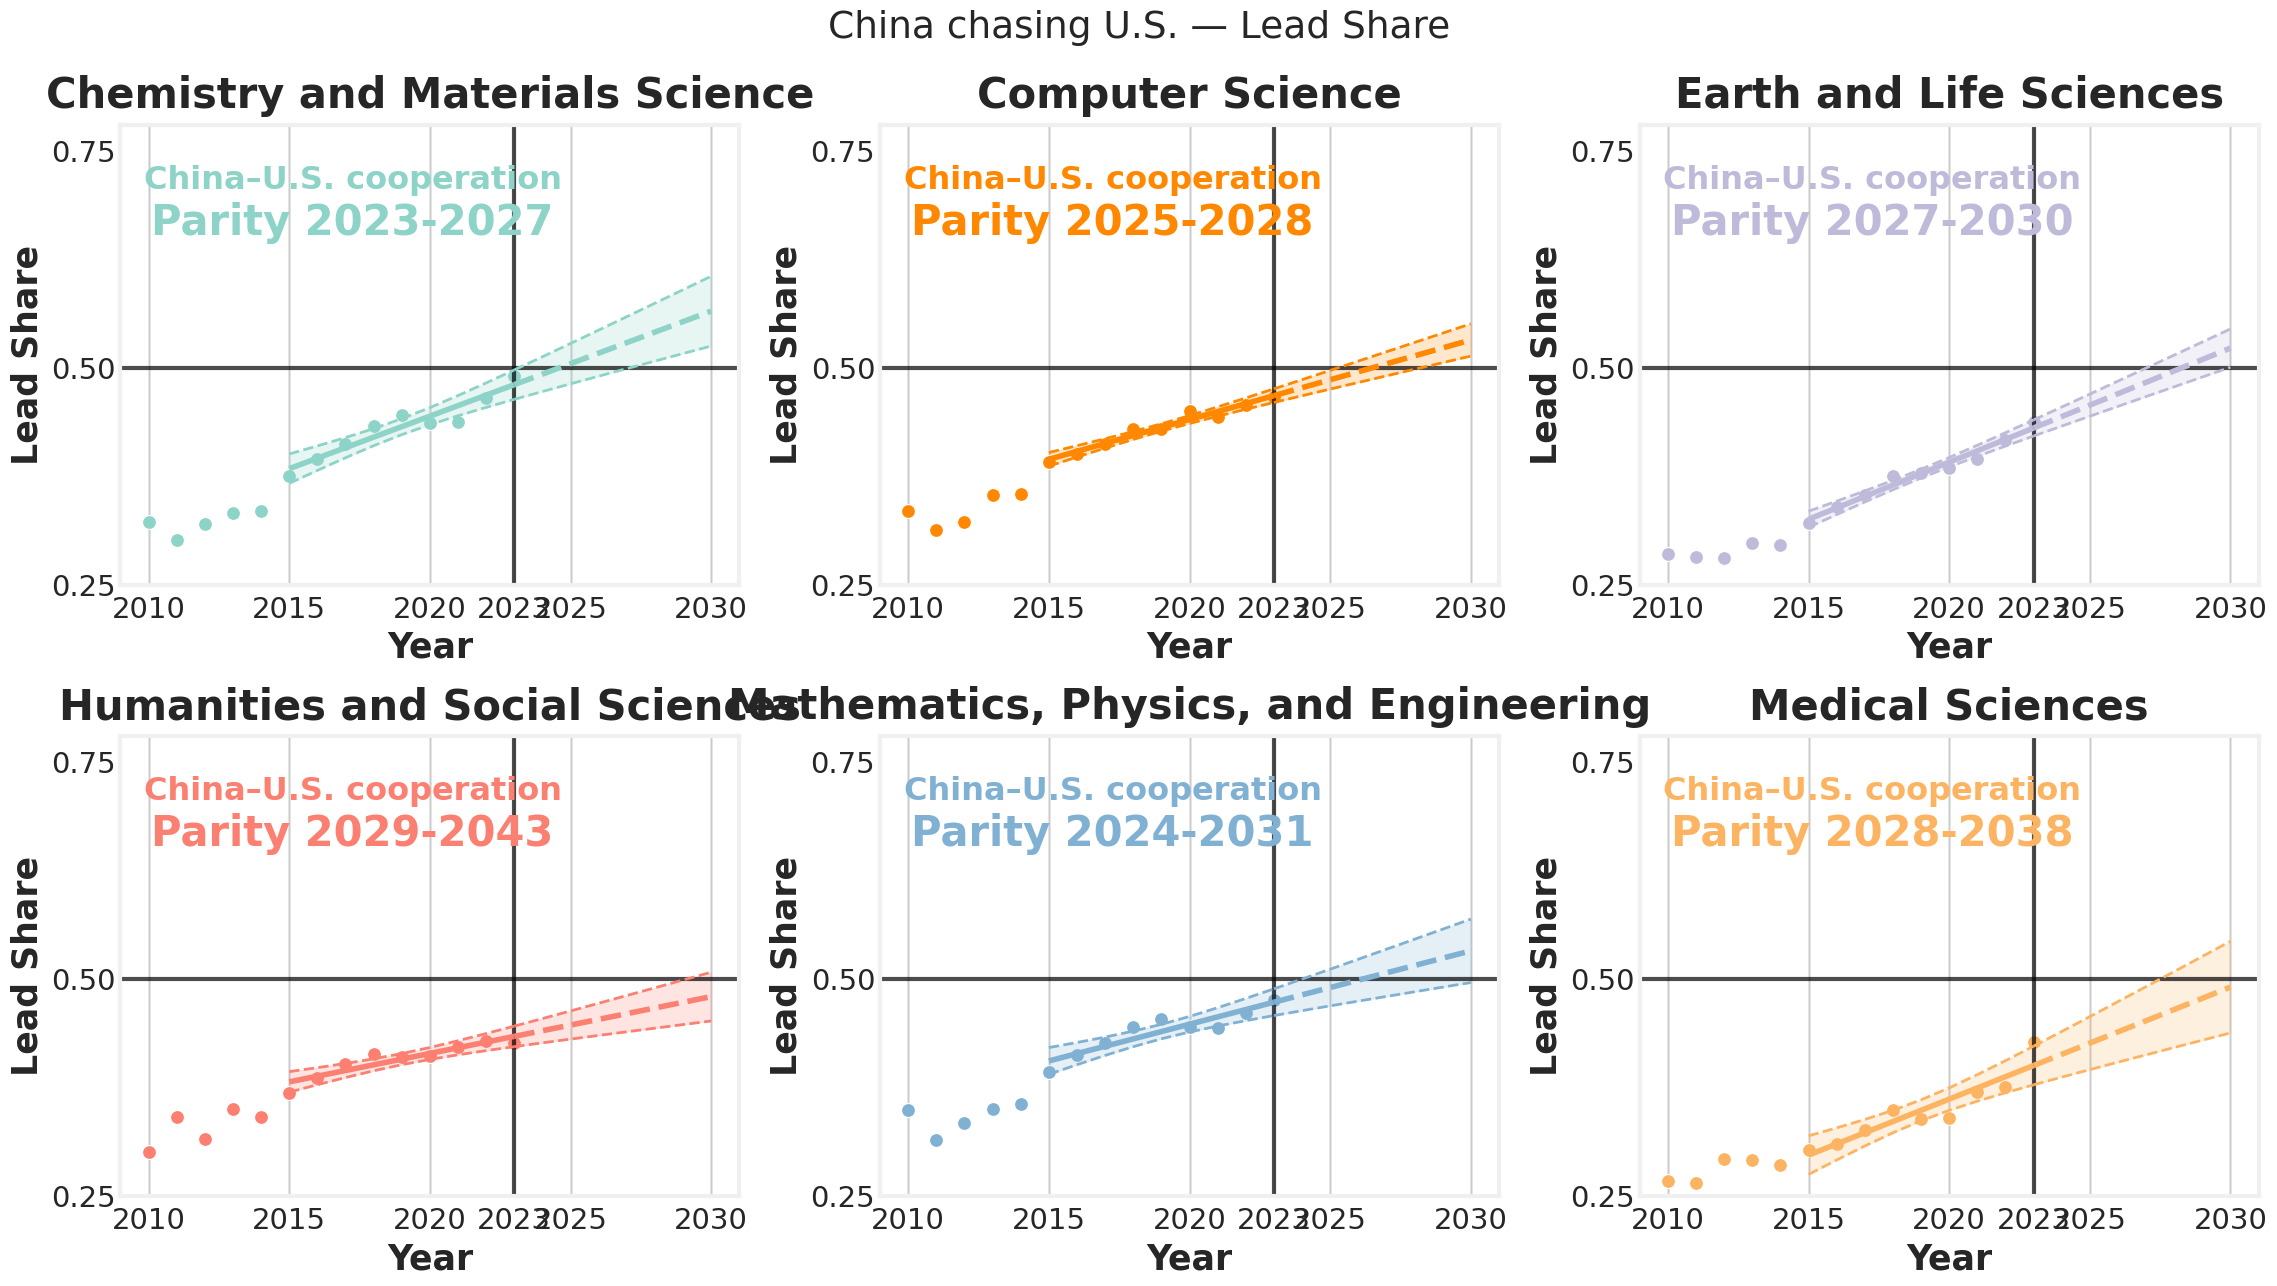

In [9]:
# ---------- Build drawing table (no further filtering; regression handles min points) ----------
df_draw = df_field_year.sort_values(["field","year"]).copy()

# ---------- Produce two versions ----------
# (A) Lead Share
plot_panels(
    df_draw=df_draw,
    metric="c1_lead_share",
    equal_line=0.5,
    y_range=(0.25, 0.75),
    title_suffix="Lead Share",
    save_file_name="fig_S22_lead_share"
)

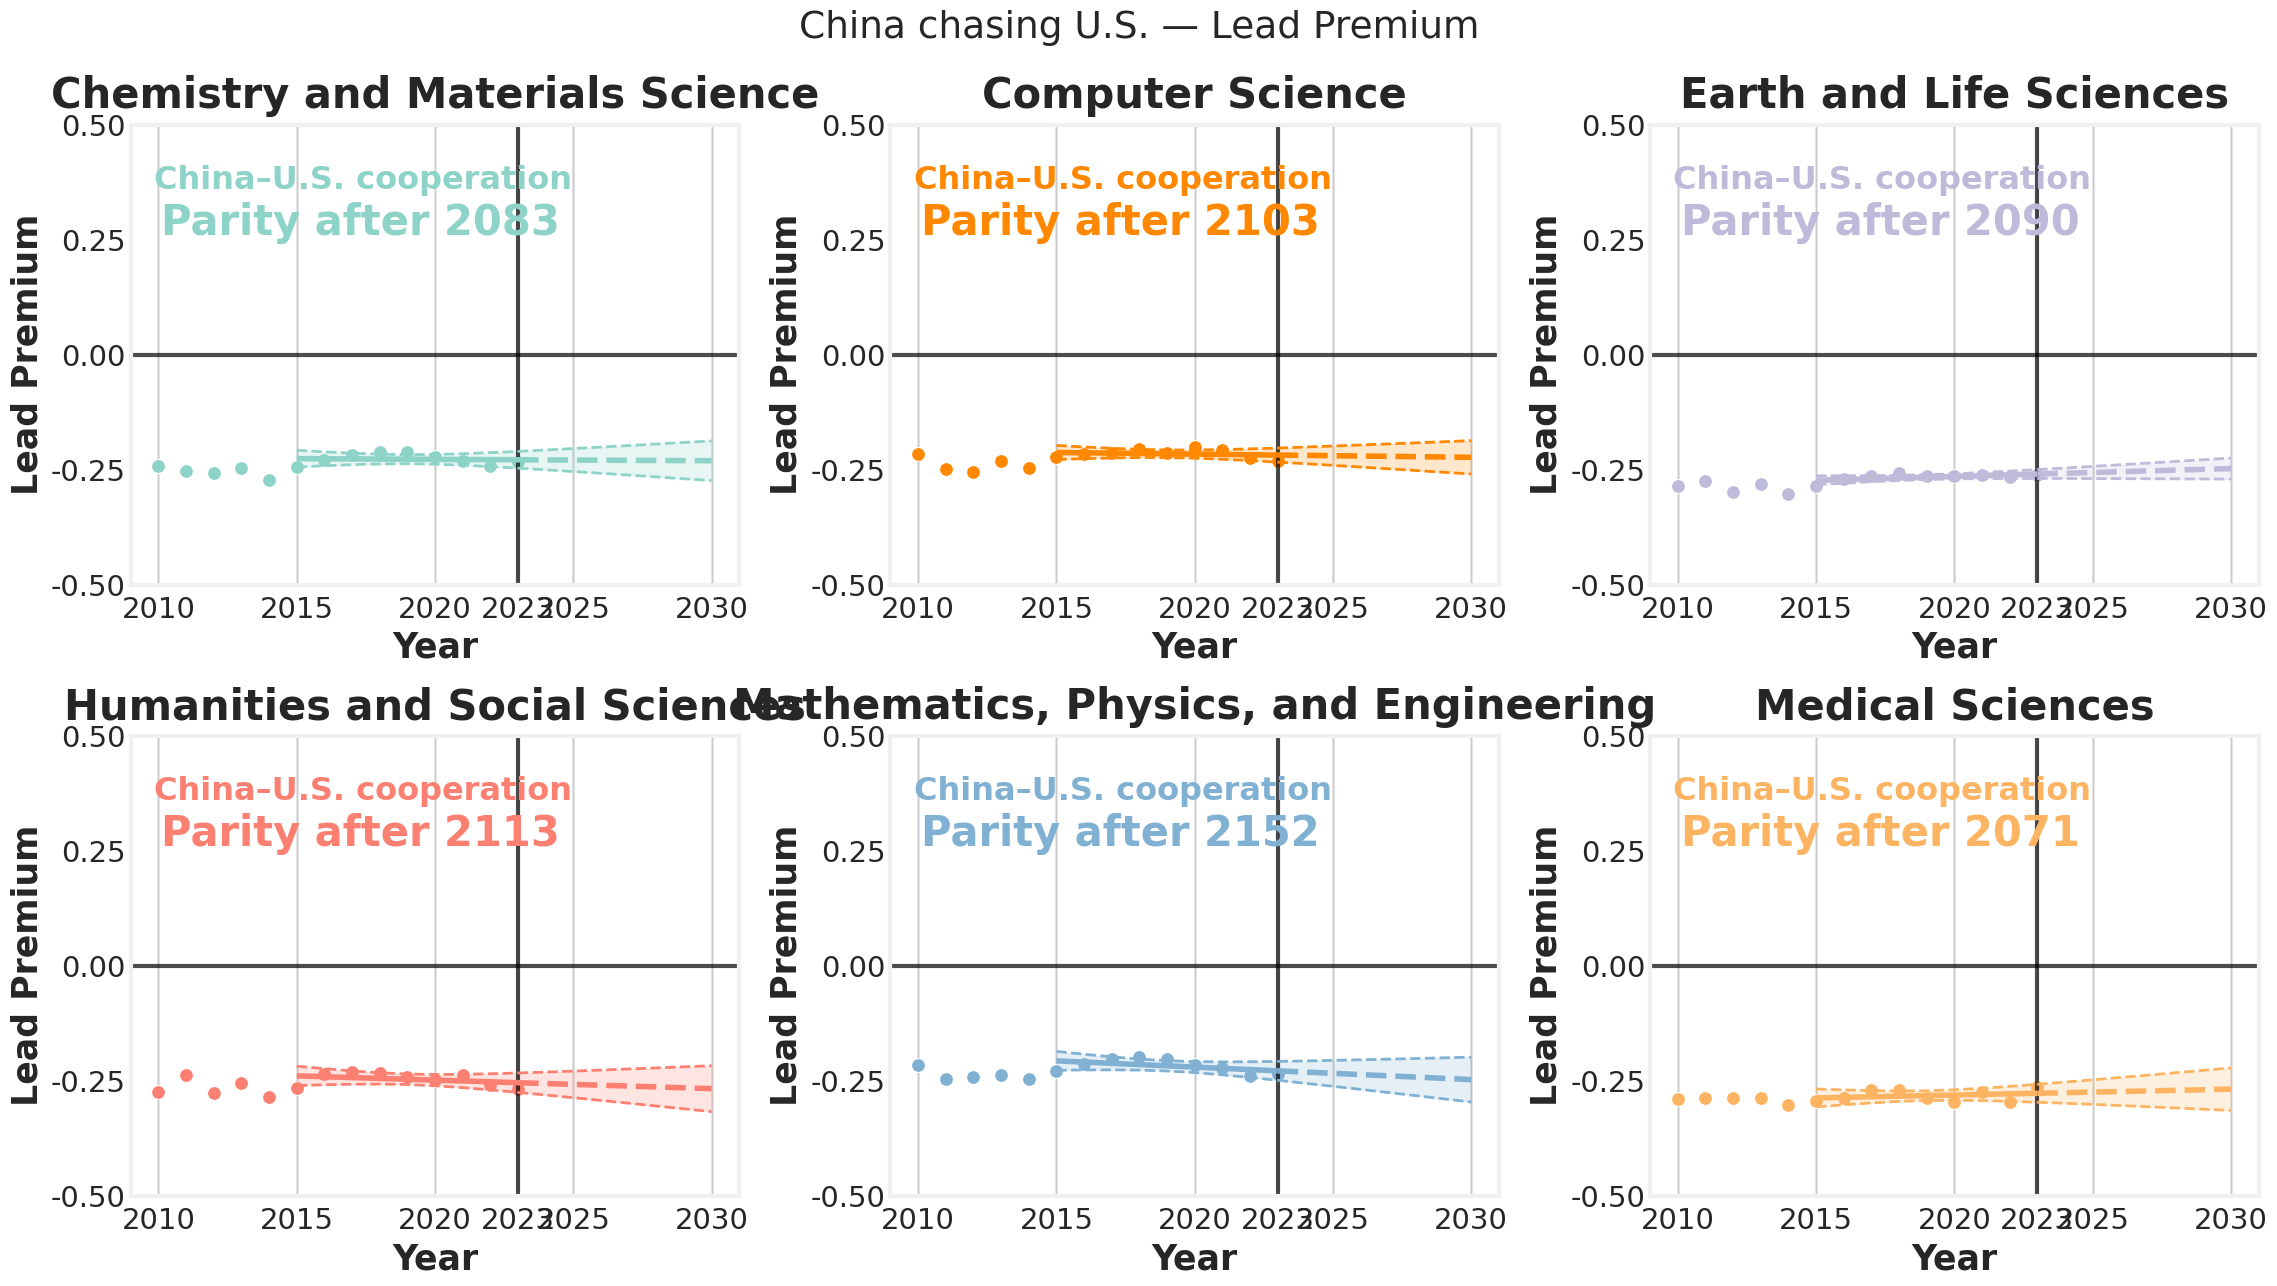

In [10]:
# (B) Lead Premium
plot_panels(
    df_draw=df_draw,
    metric="lead_premium",
    equal_line=0.0,
    y_range=(-0.5, 0.5),
    title_suffix="Lead Premium",
    save_file_name="fig_S22_lead_premium"
)

/home/renly/.local/lib/python3.11/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/renly/.local/lib/python3.11/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/renly/.local/lib/python3.11/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/renly/.local/lib/python3.11/site-packages/seaborn/_c

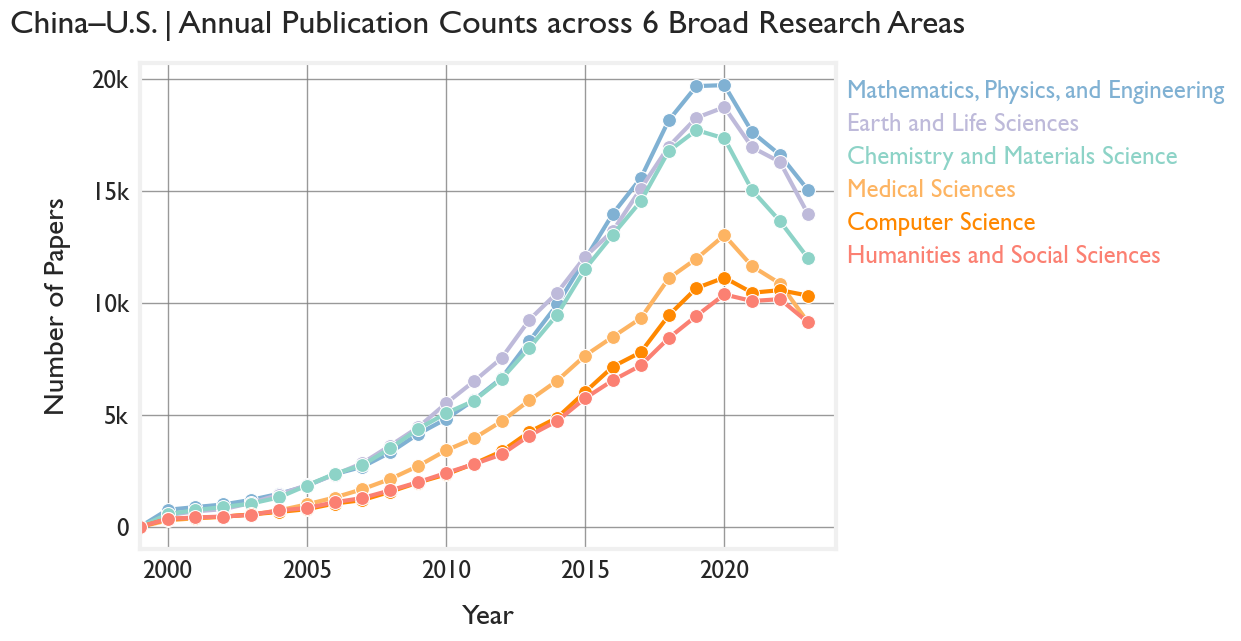

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator
import seaborn as sns

mpl.rcParams.update({
    "figure.facecolor":  "white",
    "axes.facecolor":    "white",
    "savefig.facecolor": "white",
    "savefig.edgecolor": "white",
    "savefig.transparent": False,
})

plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.set_facecolor("white")

legend_order = (df_paper_sta.groupby("field", observed=True)["pub_count"]
                .sum()
                .sort_values(ascending=False)
                .index
                .tolist())

# 3) Add hue_order=legend_order to keep legend sorted by totals
sns.lineplot(
    data=df_paper_sta.sort_values(["end_year", "pub_count"], ascending=[True, False]),
    x="end_year", y="pub_count",
    hue="field", hue_order=legend_order,
    palette=hue_colors,
    linewidth=3, marker='o', markersize=10
)

plt.xlim(2000-1, 2024)
# Keep c1–c2 context
plt.title(f"{c1}–{c2} | Annual Publication Counts across 6 Broad Research Areas", fontweight='bold', pad=22, fontsize=24)

plt.xlabel("Year", fontsize=21, fontweight='bold', labelpad=15)
plt.ylabel("Number of Papers", fontsize=21, fontweight='bold', labelpad=15)

# --- Y-axis: 5k interval + 'k' formatter ---
def _thousands_formatter(x, pos):
    if x >= 1000:
        v = np.round(x / 1000.0, 1)
        return f"{int(v)}k" if v == int(v) else f"{v}k"
    return int(x)

ax.yaxis.set_major_locator(MultipleLocator(5000))  # 5k spacing
ax.yaxis.set_major_formatter(ticker.FuncFormatter(_thousands_formatter))

plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')
plt.tick_params(axis='both', pad=8, labelsize=18)

# Legend
lg = plt.legend(loc='upper left', frameon=False, bbox_to_anchor=(0.92, 1.00),
                prop={'size': 13, 'weight': 'bold'})
for line, text in zip(lg.get_lines(), lg.get_texts()):
    cur = text.get_text()
    text.set_text(field_title.get(cur, cur))
    line.set_linewidth(0)
    text.set_color(line.get_color())
    text.set_fontweight('bold')
    text.set_fontsize(18)

plt.grid(color='grey', linestyle='-', linewidth=1, which='both', alpha=0.8, zorder=-1)
plt.show()